In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

pixel_values = feature_extractor(image, return_tensors="pt").pixel_values

In [18]:
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

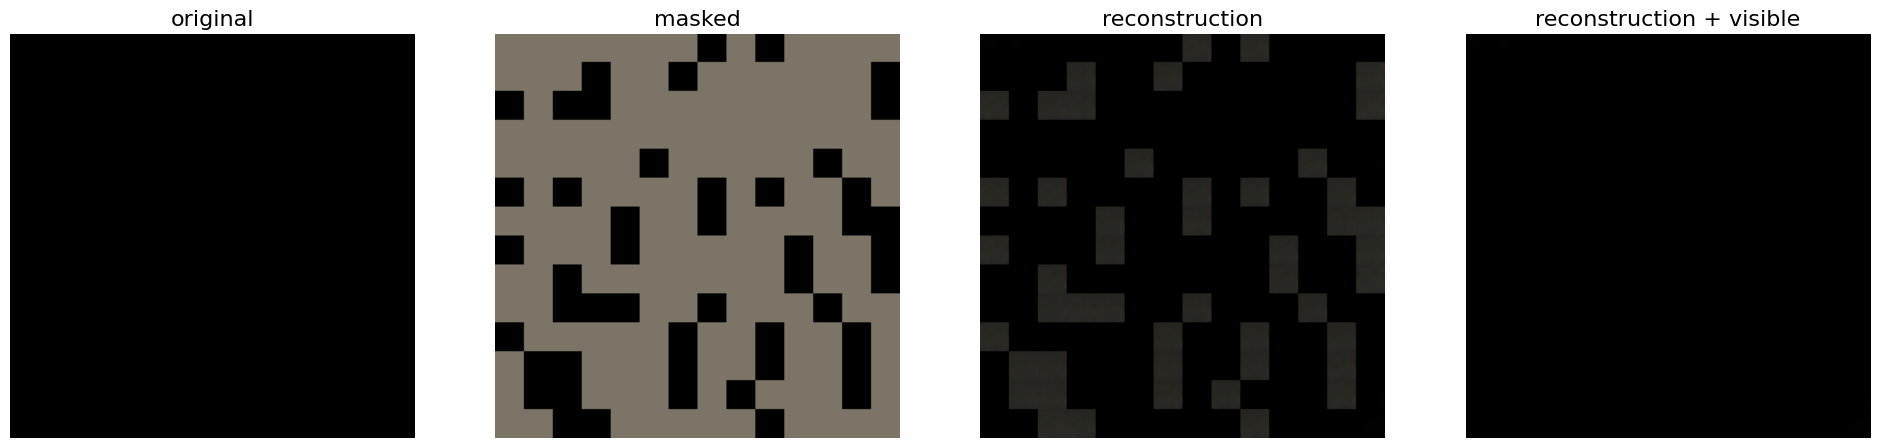

In [29]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)



Files already downloaded and verified
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


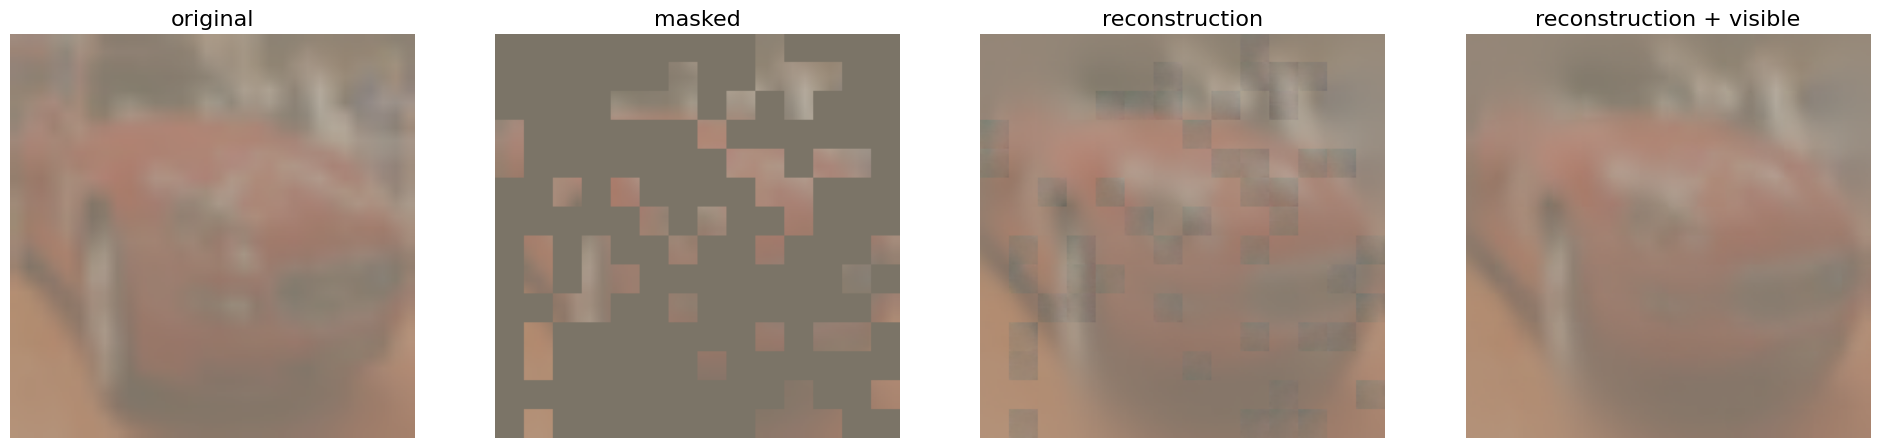

In [38]:
# Load CIFAR-10 image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of ViT
    transforms.ToTensor(),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=1, shuffle=True)

# Get a sample image
#image, _ = next(iter(cifar10_loader))

image_index = 5  # Change this to the desired index
image, _ = cifar10_dataset[image_index]
image = image.unsqueeze(0)

# Visualize the original CIFAR-10 image
#plt.imshow(np.transpose(image.squeeze().numpy(), (1, 2, 0)))
#plt.title("Original CIFAR-10 Image")
#plt.axis('off')
#plt.show()
# Visualize MAE for the CIFAR-10 image
pixel_values = image#feature_extractor(images=image, return_tensors="pt").pixel_values
print (image.shape, pixel_values.shape)
visualize(pixel_values, model)